# colab
<a href="https://colab.research.google.com/github/Ykiiii/t-less_toolkit/blob/master/yk_pytless_20231130.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg alt=Open In Colab/></a>

In [1]:
# 挂载GD
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 挂载github
using_colab = True
if using_colab:
    import torch
    import torchvision
    print(PyTorch version: , torch.__version__)
    print( Torchvision version: , torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install vispy
    !{sys.executable} -m pip install 'git+https://github.com/Ykiiii/t-less_toolkit.git'


In [3]:
!git clone https://github.com/Ykiiii/t-less_toolkit.git


Cloning into 't-less_toolkit'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 224 (delta 5), reused 16 (delta 3), pack-reused 202
Receiving objects: 100% (224/224), 1.79 MiB | 9.52 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [ ]:
/content/t-less_toolkit/t-less_download.py

In [11]:
!python t-less_toolkit/t-less_download.py --help

usage: t-less_download.py [-h] [--destination DESTINATION] [--train [obj_id ...]]
                          [--test [scene_id ...]]
                          [--sensors {primesense,kinect,canon} [{primesense,kinect,canon} ...]]
                          [--models [{cad,cad_subdivided,reconst} ...]]

Downloads and unpacks the selected parts of the T-LESS dataset. Example usage: "t-less_download.py
--train --test --models --sensors primesense" - downloads and unpacks all models and all images
from the Primesense sensor.

options:
  -h, --help            show this help message and exit
  --destination DESTINATION
                        destination folder inside which a new folder for the dataset is created
                        (default is the current folder)
  --train [obj_id ...]  IDs of objects (all are downloaded if no ID is specified)
  --test [scene_id ...]
                        IDs of scenes (all are downloaded if no ID is specified)
  --sensors {primesense,kinect,canon} [{pri

In [ ]:
!echo -e '\n' | python t-less_toolkit/t-less_download.py --train  --test  --models cad --sensors primesense



In [21]:
!python /content/t-less_toolkit/check_poses_train_imgs.py

Traceback (most recent call last):
  File "/content/t-less_toolkit/check_poses_train_imgs.py", line 9, in <module>
    from pytless import inout, renderer, misc
  File "/content/t-less_toolkit/pytless/renderer.py", line 9, in <module>
    app.use_app('PyGlet') # Set backend
  File "/usr/local/lib/python3.10/dist-packages/vispy/app/_default_app.py", line 47, in use_app
    default_app = Application(backend_name)
  File "/usr/local/lib/python3.10/dist-packages/vispy/app/application.py", line 47, in __init__
    self._use(backend_name)
  File "/usr/local/lib/python3.10/dist-packages/vispy/app/application.py", line 240, in _use
    raise RuntimeError(msg)
RuntimeError: Could not import backend "Pyglet":
No module named 'pyglet'


In [ ]:
!zip -r /content/drive/MyDrive/Dataset/t-less_v2.zip /content/t-less_v2

# PnP

In [8]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import cv2,os,copy


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


['0000.png', '0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png', '0051.png', '0052.png', '0053.png', '0054.png', '0055.png', '0056.png', '0057.png', '0058.png', '0059.png', '0060.png', '0061.png', '0062.png', '0063.png', '0064.png', '0065.png', '0066.png', '0067.png', '0068.png', '0069.png', '0070.png', '0071.png', '0072.png', '0073.png', '0074.png', '0075.png', '0076.png', '0077.png', '0078.png', '0079.png', '0080.png', '0081.png', '0082.png', '00

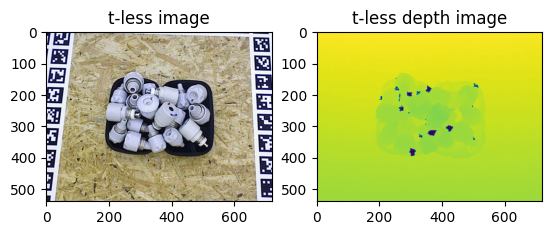

In [9]:
# 读取 展示
datadir = "E:\\DataSets\\t-less_v2\\test_primesense\\20\\"
print(os.listdir(datadir+'rgb'))

color_raw = o3d.io.read_image(datadir+'rgb\\0000.png')
depth_raw = o3d.io.read_image(datadir+'depth\\0000.png')

rgbd_image = o3d.geometry.RGBDImage.create_from_tum_format(
    color_raw, depth_raw,convert_rgb_to_intensity=False)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('t-less image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('t-less depth image')
plt.imshow(rgbd_image.depth)
# plt.show()
# show_rgbd(rgbd_image)

## aruco-code

In [1]:
import cv2
import cv2.aruco as aruco
import numpy as np
mtx=np.array([[398.12724231  , 0.      ,   304.35638757],
 [  0.       ,  345.38259888, 282.49861858],
 [  0.,           0.,           1.        ]])
dist=np.array(([[-0.58650416 , 0.59103816, -0.00443272 , 0.00357844 ,-0.27203275]]))

# Load the image
# img = cv2.imread(datadir+'rgb\\0000.png')
img = cv2.imread('RgbdData/testrgbd/111.png')
frame = img
font = cv2.FONT_HERSHEY_SIMPLEX #font for displaying text (below)
# img = cv2.imread('RgbdData/testrgbd/Snipaste_2023-12-04_09-39-06.png')

# Define the dictionary to use
dictionary = aruco.getPredefinedDictionary(aruco.DICT_6X6_50)

# Define the parameters for marker detection
parameters = aruco.DetectorParameters()

# Detect the markers in the image
corners, ids, rejectedImgPoints = aruco.detectMarkers(img, dictionary, parameters=parameters)

rvec, tvec, _ = aruco.estimatePoseSingleMarkers(corners, 0.05, mtx, dist)


# Draw the detected markers on the image
img_with_markers = aruco.drawDetectedMarkers(img, corners, ids)

(rvec-tvec).any() # get rid of that nasty numpy value array error

# aruco.drawAxis(frame, mtx, dist, rvec, tvec, 0.1) #绘制轴
# aruco.drawDetectedMarkers(frame, corners) #在标记周围画一个正方形

for i in range(rvec.shape[0]):
    aruco.drawAxis(frame, mtx, dist, rvec[i, :, :], tvec[i, :, :], 0.03)
    aruco.drawDetectedMarkers(frame, corners)
###### DRAW ID #####
cv2.putText(frame, "Id: " + str(ids), (0,64), font, 1, (0,255,0),2,cv2.LINE_AA)



# # Display the image
# cv2.imshow('Image with ArUco Markers', img_with_markers)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


AttributeError: module 'cv2.aruco' has no attribute 'drawAxis'

In [6]:
cv2.imshow(img)

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


In [10]:
img.shape

(860, 1141, 3)

In [11]:
img_with_markers.shape

(860, 1141, 3)

## artoolkitplus-code

In [10]:
import cv2
image = cv2.imread('RgbdData/testrgbd/Snipaste_2023-12-04_09-37-59.png')
# Assume that the image containing the BCH code is stored in a NumPy array called 'image'
# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale image to create a binary image
ret, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

# Find the contours in the binary image
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(image, contours, -1, (0, 255, 0), 3)

# Display the image
cv2.imshow('Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


# rebuild mesh

In [2]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import cv2,os,copy,yaml

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


['0000.png', '0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png', '0051.png', '0052.png', '0053.png', '0054.png', '0055.png', '0056.png', '0057.png', '0058.png', '0059.png', '0060.png', '0061.png', '0062.png', '0063.png', '0064.png', '0065.png', '0066.png', '0067.png', '0068.png', '0069.png', '0070.png', '0071.png', '0072.png', '0073.png', '0074.png', '0075.png', '0076.png', '0077.png', '0078.png', '0079.png', '0080.png', '0081.png', '0082.png', '00

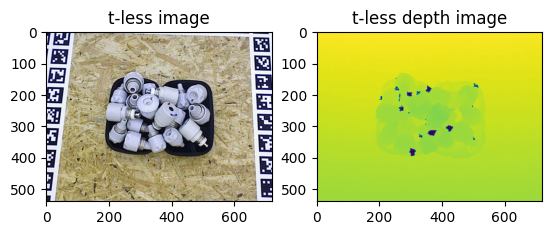

In [2]:
# 读取 展示
datadir = "E:\\DataSets\\t-less_v2\\test_primesense\\20\\"
print(os.listdir(datadir+'rgb'))

color_raw = o3d.io.read_image(datadir+'rgb\\0000.png')
depth_raw = o3d.io.read_image(datadir+'depth\\0000.png')

rgbd_image = o3d.geometry.RGBDImage.create_from_tum_format(
    color_raw, depth_raw,convert_rgb_to_intensity=False)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('t-less image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('t-less depth image')
plt.imshow(rgbd_image.depth)
# plt.show()
# show_rgbd(rgbd_image)

## 从相机位姿出发
### 从测试数据获取位姿

In [3]:
# get camera pose from test_data
def read_trajectory(filename): 
    with open(filename, 'r') as f: 
        data = yaml.safe_load(f) 
        for item in data: 

            # intrinsic
            cam_K = data[item]['cam_K'] 
            # data[item]['intrinsic'] = np.array(cam_K).reshape(3, 3) 
            data[item]['intrinsic'] = [cam_K[0],cam_K[4],cam_K[2],cam_K[5]] 
 
            # extrinsic 
            cam_R_w2c = data[item]['cam_R_w2c'] 
            cam_t_w2c = data[item]['cam_t_w2c'] 
            r = np.array(cam_R_w2c).reshape(3, 3) 
            t = np.array(cam_t_w2c).reshape(3, 1) 
            data[item]['r'] = r 
            data[item]['t'] = t 
 
            # extrinsic 
            # mat_view = np.eye(4, dtype=np.float32) # From world space to eye space 
            # mat_view[:3, :3], mat_view[3, :3] = r.T, t.T 
            # trans = np.array( 
            #     [ 
            #         [ 1, -1, -1, 1], 
            #         [ 1, -1, -1, 1], 
            #         [ 1, -1, -1, 1], 
            #         [ 1, -1, -1, 1] 
            #     ] 
            # ) 
            # data[item]['extrinsic'] = np.multiply(mat_view,trans) 
            
            # extrinsic 
            mat_view = np.eye(4, dtype=np.float32) # From world space to eye space 
            mat_view[:3, :3], mat_view[:3, 3] = r, t.squeeze() 
            data[item]['extrinsic'] = mat_view 
            yz_flip = np.eye(4, dtype=np.float32) 
            yz_flip[1, 1], yz_flip[2, 2] = -1,-1 
            data[item]['extrinsic'] = yz_flip.dot(data[item]['extrinsic']).T 
    return data 
 
filename = 'RgbdData/testrgbd/info.yml'
camera_poses = read_trajectory(filename) 

print(camera_poses[1]['r']) 
print(camera_poses[1]['t']) 
print(camera_poses[1]['extrinsic'])

[[ 0.116212 -0.993172  0.010203]
 [-0.952608 -0.114361 -0.281887]
 [ 0.281129  0.023039 -0.959393]]
[[-10.6776]
 [ 17.5621]
 [786.959 ]]
[[ 1.16212e-01  9.52608e-01 -2.81129e-01  0.00000e+00]
 [-9.93172e-01  1.14361e-01 -2.30390e-02  0.00000e+00]
 [ 1.02030e-02  2.81887e-01  9.59393e-01  0.00000e+00]
 [-1.06776e+01 -1.75621e+01 -7.86959e+02  1.00000e+00]]


### 从训练数据获取位姿

In [2]:
# get camera pose from train_data
def read_trajectory(): 
    file_dir = "E:/DataSets/t-less_v2/train_primesense/03/"
    gt_dir = file_dir+"gt.yml"
    info_dir = file_dir+"info.yml"
    with open(gt_dir, 'r') as f: 
        data1 = yaml.safe_load(f) 
    with open(info_dir, 'r') as f: 
        data2 = yaml.safe_load(f) 
    data = {}
    for item in range(len(data1)):
        data[item] = dict(data1[item][0], **data2[item])

 
    for item in data: 

        # intrinsic
        cam_K = data[item]['cam_K'] 
        # data[item]['intrinsic'] = np.array(cam_K).reshape(3, 3) 
        data[item]['intrinsic'] = [cam_K[0],cam_K[4],cam_K[2],cam_K[5]] 

        # extrinsic 
        cam_R_w2c = data[item]['cam_R_m2c'] 
        cam_t_w2c = data[item]['cam_t_m2c'] 
        r = np.array(cam_R_w2c).reshape(3, 3) 
        t = np.array(cam_t_w2c).reshape(3, 1) 
        data[item]['r'] = r 
        data[item]['t'] = t 

        # extrinsic 
        # mat_view = np.eye(4, dtype=np.float32) # From world space to eye space 
        # mat_view[:3, :3], mat_view[3, :3] = r.T, t.T 
        # trans = np.array( 
        #     [ 
        #         [ 1, -1, -1, 1], 
        #         [ 1, -1, -1, 1], 
        #         [ 1, -1, -1, 1], 
        #         [ 1, -1, -1, 1] 
        #     ] 
        # ) 
        # data[item]['extrinsic'] = np.multiply(mat_view,trans) 
        
        # extrinsic 
        mat_view = np.eye(4, dtype=np.float32) # From world space to eye space 
        mat_view[:3, :3], mat_view[:3, 3] = r, t.squeeze() 
        data[item]['extrinsic'] = mat_view 
        yz_flip = np.eye(4, dtype=np.float32) 
        yz_flip[1, 1], yz_flip[2, 2] = -1,-1 
        data[item]['extrinsic'] = yz_flip.dot(data[item]['extrinsic'])
    return data 
 
# filename = 'RgbdData/testrgbd/info.yml'
# camera_poses = read_trajectory(filename) 
camera_poses = read_trajectory()
print(camera_poses[1]['r']) 
print(camera_poses[1]['t']) 
print(camera_poses[1]['extrinsic'])
print(camera_poses[1])

[[ 0.9995743   0.02872377  0.00521556]
 [ 0.02913986 -0.99249465 -0.11876738]
 [ 0.00176502  0.11886878 -0.99290797]]
[[-14.88800206]
 [ 19.18737576]
 [634.23598402]]
[[ 9.9957430e-01  2.8723771e-02  5.2155601e-03 -1.4888002e+01]
 [-2.9139860e-02  9.9249464e-01  1.1876738e-01 -1.9187376e+01]
 [-1.7650200e-03 -1.1886878e-01  9.9290794e-01 -6.3423596e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
{'cam_R_m2c': [0.9995743, 0.02872377, 0.00521556, 0.02913986, -0.99249465, -0.11876738, 0.00176502, 0.11886878, -0.99290797], 'cam_t_m2c': [-14.88800206, 19.18737576, 634.23598402], 'obj_bb': [157, 155, 84, 84], 'obj_id': 3, 'cam_K': [1075.65091572, 0.0, 225.06888344, 0.0, 1073.90347929, 167.72159802, 0.0, 0.0, 1.0], 'depth_scale': 0.1, 'elev': 85, 'mode': 0, 'intrinsic': [1075.65091572, 1073.90347929, 225.06888344, 167.72159802], 'r': array([[ 0.9995743 ,  0.02872377,  0.00521556],
       [ 0.02913986, -0.99249465, -0.11876738],
       [ 0.00176502,  0.11886878, -0.9929079

### 从位姿重建mesh

In [84]:
volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=4.0 / 512.0,
    sdf_trunc=0.04,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)
# width, height = 720,540
width, height = 400,400
DataFolder = "E:/DataSets/t-less_v2/train_primesense/03/"
rgbd_color_paths = [DataFolder+"/rgb/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/rgb")]
rgbd_depth_paths = [DataFolder+"/depth/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/depth")]


for i in range(0,600,40): 
    print("Integrate {:d}-th image into the volume.".format(i))
    color = o3d.io.read_image(rgbd_color_paths[i]) 
    depth = o3d.io.read_image(rgbd_depth_paths[i]) 
    
    rgbd = o3d.geometry.RGBDImage.create_from_tum_format( 
        color, depth, convert_rgb_to_intensity=False 
        ) 
    
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height,  
                                                    camera_poses[i]['intrinsic'][0], 
                                                    camera_poses[i]['intrinsic'][1], 
                                                    camera_poses[i]['intrinsic'][2], 
                                                    camera_poses[i]['intrinsic'][3],) 
    volume.integrate( 
        rgbd, 
        intrinsic, 
        np.linalg.inv(camera_poses[i]['extrinsic']))

Integrate 0-th image into the volume.
Integrate 40-th image into the volume.
Integrate 80-th image into the volume.
Integrate 120-th image into the volume.
Integrate 160-th image into the volume.
Integrate 200-th image into the volume.
Integrate 240-th image into the volume.
Integrate 280-th image into the volume.
Integrate 320-th image into the volume.
Integrate 360-th image into the volume.
Integrate 400-th image into the volume.
Integrate 440-th image into the volume.
Integrate 480-th image into the volume.
Integrate 520-th image into the volume.
Integrate 560-th image into the volume.


In [85]:
print("Extract a triangle mesh from the volume and visualize it.")
mesh = volume.extract_triangle_mesh()
mesh.compute_vertex_normals()
mesh.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([mesh])


Extract a triangle mesh from the volume and visualize it.


## 从点云多向registration
### 获取点云列表

In [13]:
width, height = 720,540

DataFolder = "E:/DataSets/t-less_v2/test_primesense/20/"

rgbd_color_paths = [DataFolder+"/rgb/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/rgb")]
rgbd_depth_paths = [DataFolder+"/depth/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/depth")]
pcds = []

for i in range(0,320,300): 
    print("Integrate {:d}-th image into the volume.".format(i))
    color = o3d.io.read_image(rgbd_color_paths[i]) 
    depth = o3d.io.read_image(rgbd_depth_paths[i]) 
    
    rgbd = o3d.geometry.RGBDImage.create_from_tum_format( 
        color, depth, convert_rgb_to_intensity=False 
        ) 
    
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height,  
                                                camera_poses[i]['intrinsic'][0], 
                                                camera_poses[i]['intrinsic'][1], 
                                                camera_poses[i]['intrinsic'][2], 
                                                camera_poses[i]['intrinsic'][3],) 
    
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd,
        intrinsic)

    radius_normal = 0.005*2
    pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    # 翻转，相机小孔成像
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    pcds.append(pcd)


Integrate 0-th image into the volume.
Integrate 300-th image into the volume.


### 去掉平面

In [14]:
o3d.visualization.draw_geometries([pcd],
                                  )

In [15]:
# 平面检测
# 用ransac分割几何基元，找到支持度最大的平面
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, # 一个点与一个估计的平面的最大距离，超过即立群
                                         ransac_n=3,              # 平面随机采样点数量
                                         num_iterations=1000)     # 随机平面被采样和验证的频率
[a, b, c, d] = plane_model                                        # 对于(x,y,z)，若ax+by+cz+d=0，则该点在平面上
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

Plane equation: 0.01x + 0.84y + 0.54z + 0.85 = 0
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 


In [17]:
obb = inlier_cloud.get_oriented_bounding_box()
obb.color = (0, 1, 0)
o3d.visualization.draw_geometries([inlier_cloud, obb])

### 多向registrain

In [7]:
def pairwise_registration(source, target):
    print("Apply point-to-plane ICP")
    icp_coarse = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_coarse, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    icp_fine = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_fine,
        icp_coarse.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    transformation_icp = icp_fine.transformation
    information_icp = o3d.pipelines.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine,
        icp_fine.transformation)
    return transformation_icp, information_icp


def full_registration(pcds, max_correspondence_distance_coarse,
                      max_correspondence_distance_fine):
    pose_graph = o3d.pipelines.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(o3d.pipelines.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    for source_id in range(n_pcds):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(
                pcds[source_id], pcds[target_id])
            print("Build o3d.pipelines.registration.PoseGraph")
            if target_id == source_id + 1:  # odometry case
                odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    o3d.pipelines.registration.PoseGraphNode(
                        np.linalg.inv(odometry)))
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=True))
    return pose_graph
print("Full registration ...")
voxel_size = 0.02
max_correspondence_distance_coarse = voxel_size * 15
max_correspondence_distance_fine = voxel_size * 1.5
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    pose_graph = full_registration(pcds,
                                   max_correspondence_distance_coarse,
                                   max_correspondence_distance_fine)



Full registration ...
Apply point-to-plane ICP
[Open3D DEBUG] ICP Iteration #0: Fitness 1.0000, RMSE 0.0086
[Open3D DEBUG] Residual : 3.66e-05 (# of elements : 386896)
[Open3D DEBUG] ICP Iteration #1: Fitness 1.0000, RMSE 0.0085
[Open3D DEBUG] Residual : 3.64e-05 (# of elements : 386896)
[Open3D DEBUG] ICP Iteration #2: Fitness 1.0000, RMSE 0.0085
[Open3D DEBUG] Residual : 3.63e-05 (# of elements : 386896)
[Open3D DEBUG] ICP Iteration #3: Fitness 1.0000, RMSE 0.0085
[Open3D DEBUG] Residual : 3.61e-05 (# of elements : 386896)
[Open3D DEBUG] ICP Iteration #4: Fitness 1.0000, RMSE 0.0084
[Open3D DEBUG] Residual : 3.60e-05 (# of elements : 386896)
[Open3D DEBUG] ICP Iteration #5: Fitness 1.0000, RMSE 0.0084
[Open3D DEBUG] Residual : 3.60e-05 (# of elements : 386896)
[Open3D DEBUG] ICP Iteration #6: Fitness 1.0000, RMSE 0.0084
[Open3D DEBUG] Residual : 3.59e-05 (# of elements : 386896)
[Open3D DEBUG] ICP Iteration #7: Fitness 1.0000, RMSE 0.0084
[Open3D DEBUG] Residual : 3.59e-05 (# of elem

In [8]:
print("Optimizing PoseGraph ...")
option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    o3d.pipelines.registration.global_optimization(
        pose_graph,
        o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option)


Optimizing PoseGraph ...
[Open3D DEBUG] Validating PoseGraph - finished.
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 15 nodes and 105 edges.
[Open3D DEBUG] Line process weight : 329.579829
[Open3D DEBUG] [Initial     ] residual : 1.246582e+06, lambda : 3.160702e+01
[Open3D DEBUG] [Iteration 00] residual : 2.596411e+04, valid edges : 14, time : 0.001 sec.
[Open3D DEBUG] [Iteration 01] residual : 2.433783e+04, valid edges : 15, time : 0.001 sec.
[Open3D DEBUG] [Iteration 02] residual : 2.336588e+04, valid edges : 20, time : 0.001 sec.
[Open3D DEBUG] [Iteration 03] residual : 2.218805e+04, valid edges : 25, time : 0.008 sec.
[Open3D DEBUG] [Iteration 04] residual : 1.947703e+04, valid edges : 55, time : 0.001 sec.
[Open3D DEBUG] [Iteration 05] residual : 1.504522e+04, valid edges : 73, time : 0.001 sec.
[Open3D DEBUG] [Iteration 06] residual : 1.260331e+04, valid edges : 77, time : 0.001 sec.
[Open3D DEBUG] [Iteration 07] residual : 1.192042e+04, valid edges : 79, ti

In [9]:
print("Transform points and display")
for point_id in range(len(pcds)):
    print(pose_graph.nodes[point_id].pose)
    pcds[point_id].transform(pose_graph.nodes[point_id].pose)
o3d.visualization.draw_geometries(pcds,
                                  )


Transform points and display
[[ 1.00000000e+00 -5.98479599e-17  0.00000000e+00  0.00000000e+00]
 [ 4.72712147e-17  1.00000000e+00  3.46944695e-18  6.93889390e-18]
 [ 0.00000000e+00 -3.46944695e-18  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99998114e-01 -1.47667726e-03  1.26143657e-03  2.12222478e-04]
 [ 1.47734450e-03  9.99998769e-01 -5.28183720e-04 -2.92646437e-04]
 [-1.26065506e-03  5.30046300e-04  9.99999065e-01 -6.03862992e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.99998738  0.00491799 -0.0010306   0.00334892]
 [-0.0049225   0.99997812 -0.00441803 -0.00129349]
 [ 0.00100885  0.00442305  0.99998971 -0.00155182]
 [ 0.          0.          0.          1.        ]]
[[ 0.99944525 -0.03170998  0.01018194  0.02750909]
 [ 0.03169716  0.99949651  0.00141763  0.00671898]
 [-0.01022177 -0.0010941   0.99994716 -0.00130542]
 [ 0.          0.          0.          1.        ]]
[[ 9.99999655e-01  7.99